https://stellargraph.readthedocs.io/en/stable/demos/graph-classification/dgcnn-graph-classification.html

In [1]:
import pandas as pd
import numpy as np

import stellargraph as sg
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import DeepGraphCNN
from stellargraph import StellarGraph

from stellargraph import datasets

from sklearn import model_selection
from IPython.display import display, HTML

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow.keras.losses import binary_crossentropy
import tensorflow as tf

import os

In [2]:
file_dirs = ["/Users/morganoneka/Box/My Stuff/GraphClassification/GiottoOutput_Binarized/" + x for x in ['Chronic Pancreatitis', 'IPMN', 'MCN', 'PanIN', 'PDAC']]

In [3]:
idx = [len(os.listdir(x)) for x in file_dirs]

In [4]:
celltypes = []

for dirname in file_dirs:
    files = os.listdir(dirname)
    csvs = [x for x in files if x.endswith(".csv")]
    for f in csvs:
        mydf = pd.read_csv(dirname + "/" + f)
#         mydf['weight'] = [abs(x) for x in mydf['weight']]
        celltypes = celltypes + (list(set(mydf['source'])))
        celltypes = celltypes + (list(set(mydf['target'])))
        celltypes = list(set(celltypes))

In [5]:
node_data = pd.DataFrame(
            {"celltype": [str(x) for x in range(len(celltypes))]}, index=celltypes
        )

In [6]:
def get_graphs(dirname):
    my_graphs=[]
    files = os.listdir(dirname)
    csvs = [x for x in files if x.endswith(".csv")]
    for f in csvs:
        mydf = pd.read_csv(dirname + "/" + f)
        mydf['weight'] = [abs(x) for x in mydf['weight']]
        # 1 = tumor
        # 2 = immune 
        # 3 = other
#         node_data = pd.DataFrame(
#             {"celltype": ["1", "2", "2", "2", "2", "3"]}, index=["Tumor", "APC", "Helper T-Cell", "CTL", "T-reg", "Other"]
#         )
        
        weighted_features = StellarGraph(nodes=node_data, edges=mydf, edge_type_column='type')
        my_graphs.append(weighted_features)
    return(my_graphs)

In [7]:
cp_graphs = get_graphs(file_dirs[0])
ipmn_graphs = get_graphs(file_dirs[1])
mcn_graphs = get_graphs(file_dirs[2])
panin_graphs = get_graphs(file_dirs[3])
pdac_graphs = get_graphs(file_dirs[4])

In [8]:
all_graphs = cp_graphs + pdac_graphs
labels = [0 for x in range(len(cp_graphs))] + [1 for x in range(len(pdac_graphs))]

# all_graphs = cp_graphs + ipmn_graphs + mcn_graphs + panin_graphs + pdac_graphs
# labels = [0 for x in range(len(cp_graphs))] + [1 for x in range(len(ipmn_graphs))] + [1 for x in range(len(mcn_graphs))] + [1 for x in range(len(panin_graphs))] + [2 for x in range(len(pdac_graphs))]

graph_labels = pd.Series(labels)


In [9]:
generator = PaddedGraphGenerator(graphs=all_graphs)

In [10]:
k = 35  # the number of rows for the output tensor
layer_sizes = [32, 32, 32, 1]

dgcnn_model = DeepGraphCNN(
    layer_sizes=layer_sizes,
    activations=["tanh", "tanh", "tanh", "tanh"],
    k=k,
    bias=False,
    generator=generator,
)
x_inp, x_out = dgcnn_model.in_out_tensors()

In [11]:
x_out = Conv1D(filters=16, kernel_size=sum(layer_sizes), strides=sum(layer_sizes))(x_out)
x_out = MaxPool1D(pool_size=2)(x_out)

x_out = Conv1D(filters=32, kernel_size=5, strides=1)(x_out)

x_out = Flatten()(x_out)

x_out = Dense(units=128, activation="relu")(x_out)
x_out = Dropout(rate=0.5)(x_out)

predictions = Dense(units=1, activation="sigmoid")(x_out)



In [12]:
model = Model(inputs=x_inp, outputs=predictions)

model.compile(
    optimizer=Adam(lr=0.0001), loss=binary_crossentropy, metrics=["acc"],
)

In [13]:
train_graphs, test_graphs = model_selection.train_test_split(
    graph_labels, train_size=0.9, test_size=None, stratify=graph_labels,
)

In [14]:
gen = PaddedGraphGenerator(graphs=all_graphs)

train_gen = gen.flow(
    list(train_graphs.index - 1),
    targets=train_graphs.values,
    batch_size=50,
    symmetric_normalization=False,
)

test_gen = gen.flow(
    list(test_graphs.index - 1),
    targets=test_graphs.values,
    batch_size=1,
    symmetric_normalization=False,
)

In [15]:
epochs = 500

In [16]:
# this isn't in the original code but i don't wanna accidentally overfit?
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 25, 
                                        restore_best_weights = True)

Using TensorFlow backend.


In [17]:
history = model.fit(
    train_gen, epochs=epochs, verbose=1, validation_data=test_gen, shuffle=True, callbacks =[earlystopping]
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 4 steps, validate for 17 steps
Epoch 1/500


/Users/morganoneka/miniconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Users/morganoneka/miniconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


4/4 [==============================] - 1s 342ms/step - loss: 0.7111 - acc: 0.4902 - val_loss: 0.6458 - val_acc: 0.7059
Epoch 2/500
4/4 [==============================] - 0s 24ms/step - loss: 0.6225 - acc: 0.6863 - val_loss: 0.6174 - val_acc: 0.7059
Epoch 3/500
4/4 [==============================] - 0s 24ms/step - loss: 0.6246 - acc: 0.6601 - val_loss: 0.6071 - val_acc: 0.7059
Epoch 4/500
4/4 [==============================] - 0s 25ms/step - loss: 0.5776 - acc: 0.6667 - val_loss: 0.6041 - val_acc: 0.7059
Epoch 5/500
4/4 [==============================] - 0s 24ms/step - loss: 0.5790 - acc: 0.6732 - val_loss: 0.6047 - val_acc: 0.7059
Epoch 6/500
4/4 [==============================] - 0s 23ms/step - loss: 0.5851 - acc: 0.6732 - val_loss: 0.6063 - val_acc: 0.7059
Epoch 7/500
4/4 [==============================] - 0s 24ms/step - loss: 0.5778 - acc: 0.6732 - val_loss: 0.6067 - val_acc: 0.7059
Epoch 8/500
4/4 [==============================] - 0s 23ms/step - loss: 0.5579 - acc: 0.6732 - val_lo

In [20]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

  ...
    to  
  ['...']
17/17 [==============================] - 0s 2ms/step - loss: 0.4361 - acc: 0.7647

Test Set Metrics:
	loss: 0.4361
	acc: 0.7647


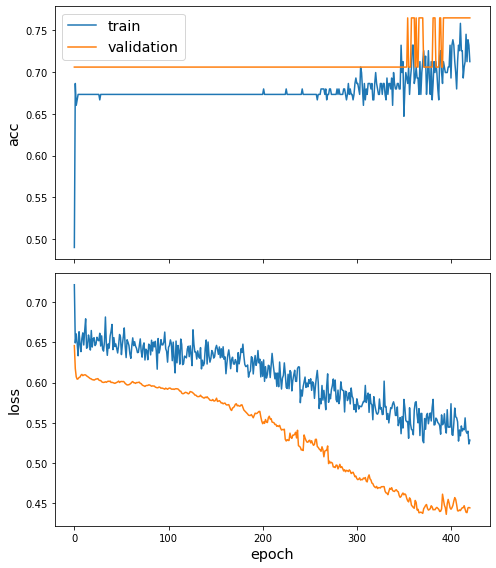

In [21]:
sg.utils.plot_history(history)